In [3]:
%pip install requests
%pip install pandas
%pip install plotly
%pip install osmnx
%pip install folium
%pip install scipy scikit-learn
%pip install simpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import requests as rq
import os
import json
import pandas as pd
import IPython
import plotly.express as px
import osmnx as ox
import folium
import geopandas as gpd
import networkx as nx
import math
import simpy

DATA_BASE = "data"
TIMETABLE_FILE = "timetable"
STOPS_FILE = "stops"
PATHS_FILE = "paths"
FILE_EXT = ".json"

In [2]:
ROUTE_API = lambda id: f"http://apicms.ebms.vn/businfo/getroutebyid/{id}"
TIMETABLE_API = lambda route: f"http://apicms.ebms.vn/businfo/gettimetablebyroute/{route}"
ROUTEVAR_API = lambda route: f"http://apicms.ebms.vn/businfo/getvarsbyroute/{route}"
STOPS_API = lambda id, varId: f"http://apicms.ebms.vn/businfo/getstopsbyvar/{id}/{varId}"
PATHS_API = lambda id, varId: f"http://apicms.ebms.vn/businfo/getpathsbyvar/{id}/{varId}"

def LoadData(route, source, api):
    source += FILE_EXT
    dir_path = os.path.join(os.getcwd(), DATA_BASE, str(route))
    file_path = os.path.join(os.getcwd(), DATA_BASE, str(route), source)

    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    if not os.path.exists(file_path):
        response = rq.get(api)
        with open(file_path, "w+", encoding="utf-8") as f:
            string = json.dumps(response.json(), ensure_ascii=False)
            f.write(string)
            
    return pd.read_json(file_path, encoding="utf-8")

In [3]:
class StationModel():
    def __init__(self, routeId, varId) -> None:
        src = STOPS_FILE + str(varId)
        api = STOPS_API(id=routeId, varId=varId)
        stops_df = LoadData(route=routeId, source=src, api=api)
        self.stops_df = stops_df[["StopId", "Lat", "Lng"]]
        self.stops_df = self.stops_df.rename(columns={"StopId":"stop_id", "Lat":"lat", "Lng":"lng"})

In [4]:
class BusModel():
    def __init__(self, id) -> None:
        self.stations = dict()
        self.paths_df = dict()
        timetables_df = LoadData(route=id, source=TIMETABLE_FILE, api=TIMETABLE_API(id))
        for varId in timetables_df["RouteVarId"]:
            self.stations[varId] = StationModel(routeId=id, varId=varId)
            self.paths_df[varId] = LoadData(route=id, source=PATHS_FILE, api=PATHS_API(id, varId=varId))

In [ ]:
utn = ox.settings.useful_tags_node
oxna = ox.settings.osm_xml_node_attrs
oxnt = ox.settings.osm_xml_node_tags
utw = ox.settings.useful_tags_way
oxwa = ox.settings.osm_xml_way_attrs
oxwt = ox.settings.osm_xml_way_tags
utn = list(set(utn + oxna + oxnt))
utw = list(set(utw + oxwa + oxwt))
ox.settings.all_oneway = False
ox.settings.useful_tags_node = utn
ox.settings.useful_tags_way = utw
ox.settings.timeout=1200

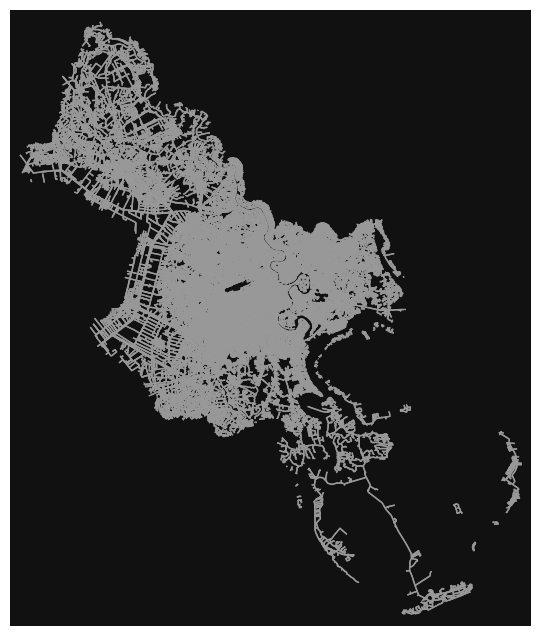

In [173]:
HCM_NETWORK = "./data/hcm.graphml"
if not os.path.exists(HCM_NETWORK):
    G = ox.graph_from_place("Ho Chi Minh City", retain_all=True, truncate_by_edge=True, buffer_dist=1000)
    ox.save_graphml(G, HCM_NETWORK)
else:
    G = ox.load_graphml(HCM_NETWORK)

ox.add_edge_speeds(G, hwy_speeds=60, fallback=50)
ox.add_edge_travel_times(G)
fig, ax = ox.plot_graph(G, node_size=0)

In [174]:
buses = list()
bus_ids = [8]
for id in bus_ids:
    buses.append(BusModel(id))

stations = buses[0].stations[15].stops_df
stations["edge"] = ox.nearest_edges(G, X=stations["lng"], Y=stations["lat"])
stations.drop_duplicates(subset="edge", inplace=True, ignore_index=True)

def get_routes(station):
    if station.name + 1 != stations.shape[0]:
        return ox.shortest_path(G, station["edge"][0], stations.loc[station.name + 1, "edge"][0])
    else:
        return list(station["edge"][:2])

stations["route"] = stations.apply(get_routes, axis="columns")
stations.reset_index(drop=True, inplace=True)
stations

,stop_id,lat,lng,edge,route
0,496,10.733545,106.656357,"(4652534427, 2495870411, 0)","[4652534427, 5755051488, 366450563, 5755153785..."
1,502,10.736460,106.656346,"(6433515438, 5755053133, 0)","[6433515438, 6432690983, 5816764351, 575515378..."
2,499,10.738769,106.656427,"(5755153782, 6758003387, 0)","[5755153782, 6758003387, 2040317179, 204031718..."
3,542,10.744513,106.656802,"(6757924465, 5764804979, 0)","[6757924465, 5764804979, 6450096913, 675792447..."
4,501,10.746073,106.659763,"(6449960694, 6450096946, 0)","[6449960694, 6450096946, 4616320836, 366442410..."
...,...,...,...,...,...
65,1919,10.873515,106.809458,"(9339328179, 9417468295, 0)","[9339328179, 9417468295, 6956996792, 695699679..."
66,7644,10.874405,106.806995,"(8372428300, 8372428302, 0)","[8372428300, 8372428302, 5763376688, 576289046..."
67,7648,10.875886,106.804968,"(5762890477, 6768441603, 0)","[5762890477, 6768441603, 6326613470, 632661347..."
68,7623,10.876655,106.802537,"(2949182378, 6768441588, 0)","[2949182378, 6768441590, 2949182366, 294918236..."


In [175]:
loop_filt = stations.apply(
    lambda station: 
    len(set(station["route"]).intersection(
        set(stations.loc[station.name - 1, "route"] if station.name != 0 else []))
    ) > 1
    , axis="columns")
loop_routes = stations[loop_filt]
stations.drop(loop_routes.index, inplace=True)

stations.reset_index(inplace=True, drop=True)
stations.drop("route", axis="columns", inplace=True)
stations["route"] = stations.apply(get_routes, axis="columns")

stations

,stop_id,lat,lng,edge,route
0,496,10.733545,106.656357,"(4652534427, 2495870411, 0)","[4652534427, 5755051488, 366450563, 5755153785..."
1,502,10.736460,106.656346,"(6433515438, 5755053133, 0)","[6433515438, 6432690983, 5816764351, 575515378..."
2,499,10.738769,106.656427,"(5755153782, 6758003387, 0)","[5755153782, 6758003387, 2040317179, 204031718..."
3,542,10.744513,106.656802,"(6757924465, 5764804979, 0)","[6757924465, 5764804979, 6450096913, 675792447..."
4,501,10.746073,106.659763,"(6449960694, 6450096946, 0)","[6449960694, 6450096946, 4616320836, 366442410..."
...,...,...,...,...,...
62,1919,10.873515,106.809458,"(9339328179, 9417468295, 0)","[9339328179, 9417468295, 6956996792, 695699679..."
63,7644,10.874405,106.806995,"(8372428300, 8372428302, 0)","[8372428300, 8372428302, 5763376688, 576289046..."
64,7648,10.875886,106.804968,"(5762890477, 6768441603, 0)","[5762890477, 6768441603, 6326613470, 632661347..."
65,7623,10.876655,106.802537,"(2949182378, 6768441588, 0)","[2949182378, 6768441590, 2949182366, 294918236..."


In [176]:
def get_travel_times(station):
    return sum(ox.utils_graph.get_route_edge_attributes(G, station["route"], "travel_time"))
stations["time"] = stations.apply(get_travel_times, axis="columns")
stations["time"].sum()

2247.3000000000006

In [177]:
buses[0].stations[15].stops_df

,stop_id,lat,lng,edge,route,time
0,496,10.733545,106.656357,"(4652534427, 2495870411, 0)","[4652534427, 5755051488, 366450563, 5755153785...",28.1
1,502,10.736460,106.656346,"(6433515438, 5755053133, 0)","[6433515438, 6432690983, 5816764351, 575515378...",16.0
2,499,10.738769,106.656427,"(5755153782, 6758003387, 0)","[5755153782, 6758003387, 2040317179, 204031718...",44.7
3,542,10.744513,106.656802,"(6757924465, 5764804979, 0)","[6757924465, 5764804979, 6450096913, 675792447...",24.9
4,501,10.746073,106.659763,"(6449960694, 6450096946, 0)","[6449960694, 6450096946, 4616320836, 366442410...",78.7
...,...,...,...,...,...,...
62,1919,10.873515,106.809458,"(9339328179, 9417468295, 0)","[9339328179, 9417468295, 6956996792, 695699679...",48.9
63,7644,10.874405,106.806995,"(8372428300, 8372428302, 0)","[8372428300, 8372428302, 5763376688, 576289046...",24.3
64,7648,10.875886,106.804968,"(5762890477, 6768441603, 0)","[5762890477, 6768441603, 6326613470, 632661347...",28.3
65,7623,10.876655,106.802537,"(2949182378, 6768441588, 0)","[2949182378, 6768441590, 2949182366, 294918236...",42.1


In [178]:
routes = stations["route"]
route_map = ox.plot_route_folium(G, routes.iloc[0], None, color="#0000ff", tiles="openstreetmap")
for route in routes[1:]:
    route_map = ox.plot_route_folium(G, route, route_map, color="#0000ff", tiles="openstreetmap")
route_map

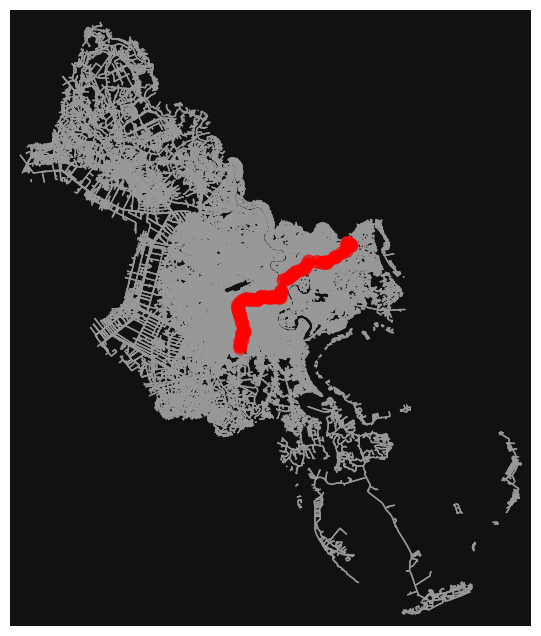

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [172]:
ox.plot_graph_routes(G, stations["route"], node_size=0, edge_linewidth=1)